In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# !pip install category_encoders

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots

import plotly.express as px
import plotly.graph_objects as go
import category_encoders as ce

from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import make_scorer, f1_score, roc_auc_score, accuracy_score, classification_report, confusion_matrix, balanced_accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [4]:
# df = pd.read_csv("/content/drive/MyDrive/ML/BNP/train.csv.zip", compression="zip")
# train, test = train_test_split(df, train_size=0.7)

In [6]:
df = pd.read_csv("./dataset/train.csv.zip", compression="zip")
train, test = train_test_split(df, train_size=0.7)

In [7]:
# Function to convert to hexavigesimal base
def az_to_int(az, nanVal=None):
    if az==az:  #catch NaN
        hv = 0
        for i in range(len(az)):
            hv += (ord(az[i].lower())-ord('a')+1)*26**(len(az)-1-i)
        return hv
    else:
        if nanVal is not None:
            return nanVal
        else:
            return az

In [8]:
def clean_data(df, cat_cols):
    df.v22 = df.v22.apply(az_to_int)
    df.drop(columns='ID', inplace=True)
    for cat_col in cat_cols:
        df[cat_col].fillna("__MISS__", inplace=True)
    return df

In [9]:
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
train = clean_data(train, cat_cols)
test = clean_data(test, cat_cols)

In [10]:
def dplot(data, column, target):
    a = data[column].fillna(data[column].median())
    fig, axes = plt.subplots(figsize=(20, 6), ncols=2, nrows=1)
    sns.kdeplot(data=data, x=column, hue=target, ax=axes[0])
    sns.kdeplot(a, hue=data[target], ax=axes[1])

In [11]:
def catplot(data, column, target):
    x = pd.crosstab(data[column], data[target])
    print(x.apply(lambda x: x/x.sum(), axis='rows'))

In [12]:
y_train = train.pop('target')
y_test = test.pop('target')

In [13]:
cat_encoder = ce.TargetEncoder(cols=cat_cols,  smoothing=100)
train = cat_encoder.fit_transform(train, y=y_train)
test = cat_encoder.transform(test, y=y_test)

In [14]:
# imputer = KNNImputer(weights="distance", copy=False)
# imputer.fit_transform(train)

In [15]:
simple_imputer = SimpleImputer(strategy="median", copy=False)
train = simple_imputer.fit_transform(train)
test = simple_imputer.transform(test)

In [16]:
def plot_prob_dist(yhat_prob, y):
    plt.figure()
    preds = pd.DataFrame({"yhat_prob_test": yhat_prob[:,1], "y_test": y})
    sns.kdeplot(x=preds['yhat_prob_test'], hue=preds['y_test'])
    plt.show()
    
def print_classification_report(clf, test, y_test):
    yhat_test = clf.predict(test)
    yhat_prob_test = clf.predict_proba(test)
    print("********************************************************")
    print("Accuracy on Test data ", accuracy_score(y_test, yhat_test))
    print("********************************************************")
    print("F1 on Test data ", f1_score(y_test, yhat_test))
    print("********************************************************")
    print("AUC ROC on Test data ", roc_auc_score(y_test, yhat_test))
    print("********************************************************")
    print("Confusion matrix \n", confusion_matrix(y_test, yhat_test))
    print("********************************************************")
    print(classification_report(y_test, yhat_test))
    print("********************************************************")
    plot_prob_dist(yhat_prob_test, y_test)

### AdaBoost

## AdaBoost performance wrt no. of estimators

In [17]:
scoring = {'AUC': make_scorer(roc_auc_score), 'Accuracy': make_scorer(accuracy_score), 
           "F1 Score": make_scorer(f1_score), "BalancedAccuracy": make_scorer(balanced_accuracy_score)}

In [25]:
lr = [0.001, 0.005, 0.01, 0.05, 0.1, 1]
params = {"learning_rate": lr}
base_clf = DecisionTreeClassifier(max_depth=1, random_state=1234)
clf = AdaBoostClassifier(base_estimator=base_clf, random_state=1234, n_estimators=100)
gs = GridSearchCV(clf, cv=5, n_jobs=-2, param_grid=params, scoring=scoring, return_train_score=True, refit="BalancedAccuracy")
gs.fit(train, y_train)

GridSearchCV(cv=5,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                                                random_state=1234),
                                          n_estimators=100, random_state=1234),
             n_jobs=-2,
             param_grid={'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 1]},
             refit='BalancedAccuracy', return_train_score=True,
             scoring={'AUC': make_scorer(roc_auc_score),
                      'Accuracy': make_scorer(accuracy_score),
                      'BalancedAccuracy': make_scorer(balanced_accuracy_score),
                      'F1 Score': make_scorer(f1_score)})

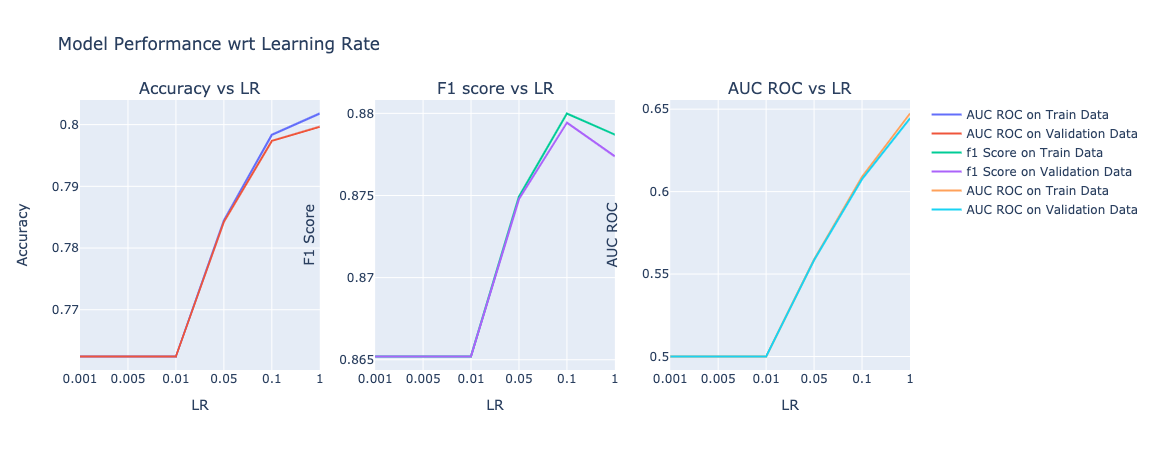

In [26]:
fig = make_subplots(rows=1, cols=3, subplot_titles=("Accuracy vs LR", "F1 score vs LR", "AUC ROC vs LR"))
# accuracy
fig.add_trace(go.Scatter(x=lr, y=gs.cv_results_['mean_train_Accuracy'], mode='lines', name='AUC ROC on Train Data'), row=1, col=1)
fig.add_trace(go.Scatter(x=lr, y=gs.cv_results_['mean_test_Accuracy'], mode='lines', name='AUC ROC on Validation Data'), row=1, col=1)
# f1 score
fig.add_trace(go.Scatter(x=lr, y=gs.cv_results_['mean_train_F1 Score'], mode='lines', name='f1 Score on Train Data'), row=1, col=2)
fig.add_trace(go.Scatter(x=lr, y=gs.cv_results_['mean_test_F1 Score'], mode='lines', name='f1 Score on Validation Data'),row=1, col=2)
# auc roc
fig.add_trace(go.Scatter(x=lr, y=gs.cv_results_['mean_train_AUC'], mode='lines', name='AUC ROC on Train Data'), row=1, col=3)
fig.add_trace(go.Scatter(x=lr, y=gs.cv_results_['mean_test_AUC'], mode='lines', name='AUC ROC on Validation Data'),row=1, col=3)
# Update xaxis properties
fig.update_xaxes(title_text="LR", row=1, col=1, type='category')
fig.update_xaxes(title_text="LR", row=1, col=2, type='category')
fig.update_xaxes(title_text="LR", row=1, col=3, type='category')
# Update yaxis properties
fig.update_yaxes(title_text="Accuracy", row=1, col=1)
fig.update_yaxes(title_text="F1 Score", row=1, col=2)
fig.update_yaxes(title_text="AUC ROC",  row=1, col=3)
# update layout
fig.update_layout(title='Model Performance wrt Learning Rate')
fig.show()

********************************************************
Accuracy on Test data  0.7625156719246581
********************************************************
F1 on Test data  0.8553825393725253
********************************************************
AUC ROC on Test data  0.5875878501219729
********************************************************
Confusion matrix 
 [[ 2064  6224]
 [ 1921 24088]]
********************************************************
              precision    recall  f1-score   support

           0       0.52      0.25      0.34      8288
           1       0.79      0.93      0.86     26009

    accuracy                           0.76     34297
   macro avg       0.66      0.59      0.60     34297
weighted avg       0.73      0.76      0.73     34297

********************************************************


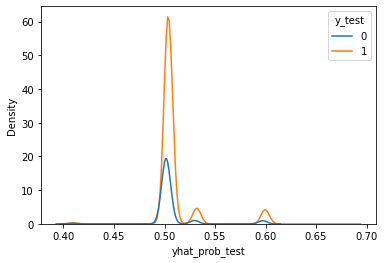

In [28]:
print_classification_report(gs.best_estimator_, test, y_test)

In [30]:
n_estimators = [10, 50, 100, 150]
params = {"n_estimators": n_estimators}
base_clf = DecisionTreeClassifier(max_depth=1, random_state=1234)
clf = AdaBoostClassifier(base_estimator=base_clf, random_state=1234, learning_rate=1)
gs = GridSearchCV(clf, cv=5, n_jobs=-2, param_grid=params, scoring=scoring, return_train_score=True, refit="BalancedAccuracy")
gs.fit(train, y_train)

GridSearchCV(cv=5,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                                                random_state=1234),
                                          learning_rate=1, random_state=1234),
             n_jobs=-2, param_grid={'n_estimators': [10, 50, 100, 150]},
             refit='BalancedAccuracy', return_train_score=True,
             scoring={'AUC': make_scorer(roc_auc_score),
                      'Accuracy': make_scorer(accuracy_score),
                      'BalancedAccuracy': make_scorer(balanced_accuracy_score),
                      'F1 Score': make_scorer(f1_score)})

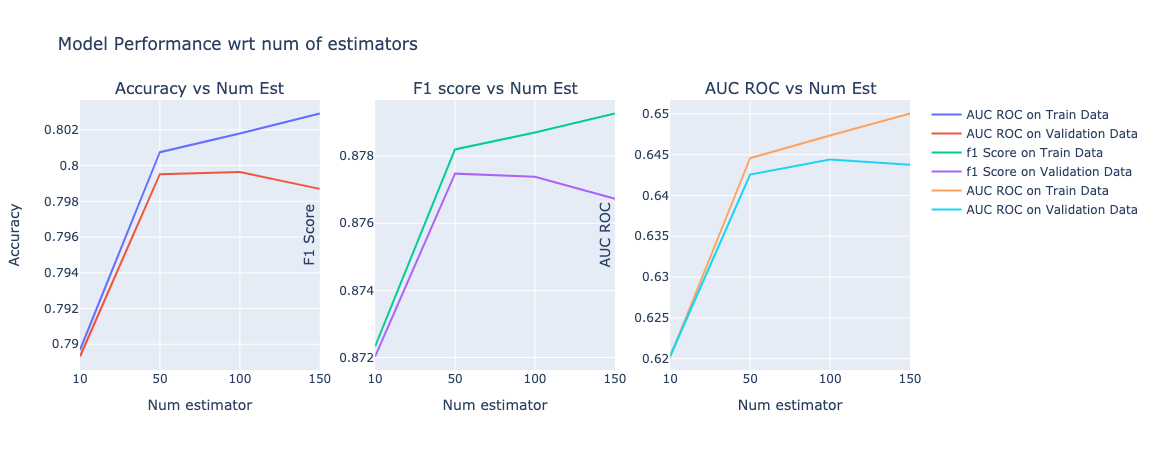

In [31]:
fig = make_subplots(rows=1, cols=3, subplot_titles=("Accuracy vs Num Est", "F1 score vs Num Est", "AUC ROC vs Num Est"))
# accuracy
fig.add_trace(go.Scatter(x=n_estimators, y=gs.cv_results_['mean_train_Accuracy'], mode='lines', name='AUC ROC on Train Data'), row=1, col=1)
fig.add_trace(go.Scatter(x=n_estimators, y=gs.cv_results_['mean_test_Accuracy'], mode='lines', name='AUC ROC on Validation Data'), row=1, col=1)
# f1 score
fig.add_trace(go.Scatter(x=n_estimators, y=gs.cv_results_['mean_train_F1 Score'], mode='lines', name='f1 Score on Train Data'), row=1, col=2)
fig.add_trace(go.Scatter(x=n_estimators, y=gs.cv_results_['mean_test_F1 Score'], mode='lines', name='f1 Score on Validation Data'), row=1, col=2)
# auc roc
fig.add_trace(go.Scatter(x=n_estimators, y=gs.cv_results_['mean_train_AUC'], mode='lines', name='AUC ROC on Train Data'), row=1, col=3)
fig.add_trace(go.Scatter(x=n_estimators, y=gs.cv_results_['mean_test_AUC'], mode='lines', name='AUC ROC on Validation Data'), row=1, col=3)
# Update xaxis properties
fig.update_xaxes(title_text="Num estimator", row=1, col=1, type='category')
fig.update_xaxes(title_text="Num estimator", row=1, col=2, type='category')
fig.update_xaxes(title_text="Num estimator", row=1, col=3, type='category')
# Update yaxis properties
fig.update_yaxes(title_text="Accuracy", row=1, col=1)
fig.update_yaxes(title_text="F1 Score", row=1, col=2)
fig.update_yaxes(title_text="AUC ROC",  row=1, col=3)
# update layout
fig.update_layout(title='Model Performance wrt num of estimators')
fig.show()

********************************************************
Accuracy on Test data  0.7625156719246581
********************************************************
F1 on Test data  0.8553825393725253
********************************************************
AUC ROC on Test data  0.5875878501219729
********************************************************
Confusion matrix 
 [[ 2064  6224]
 [ 1921 24088]]
********************************************************
              precision    recall  f1-score   support

           0       0.52      0.25      0.34      8288
           1       0.79      0.93      0.86     26009

    accuracy                           0.76     34297
   macro avg       0.66      0.59      0.60     34297
weighted avg       0.73      0.76      0.73     34297

********************************************************


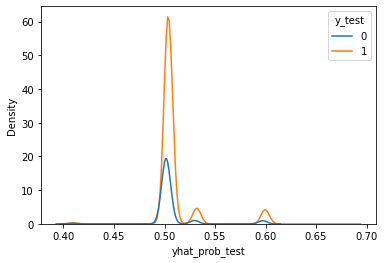

In [32]:
print_classification_report(gs.best_estimator_, test, y_test)